In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style('white')
np.random.seed(42)

from scipy.stats import ttest_rel
from scipy.stats import combine_pvalues

from gpu_utils import restrict_GPU_pytorch
from fig_helpers import add_metrics_to_df, adjust_box_widths
from paths import FIG_DIR
restrict_GPU_pytorch('0')

val_loss_key = 'auc'

orig = sns.color_palette('colorblind')
method_colors = [orig[2], orig[0], orig[1], orig[3], orig[4]]
method_colors = ['#4daf4a', '#e41a1c', '#377eb8', '#ff7f00', '#984ea3']
hue_order = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
plotted_methods = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
method_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using GPU:0


# Figure 2a: Illustration of PU Learning settings.

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8, 4))

# Traditional PU learning setup
n_examples = 750
neg = np.random.multivariate_normal((0, 0), [[.2, 0], [0, .25]], n_examples)
pos = np.random.multivariate_normal((2, 2), [[.25, .05], [.05, .25]], n_examples)

neg = np.concatenate([neg, np.zeros((n_examples, 1))], axis=1)
pos = np.concatenate([pos, np.ones((n_examples, 1))], axis=1)
neg_df = pd.DataFrame(neg, columns=['feat1', 'feat2', 'label'])
pos_df = pd.DataFrame(pos, columns=['feat1', 'feat2', 'label'])
feats_df = pd.concat([neg_df, pos_df], ignore_index=True)
sns.kdeplot(data=feats_df, x='feat1', y='feat2', hue='label', fill=True,
            ax=axs[0], legend=True, palette=[red_color, green_color], alpha=.75)

red_patch = mpatches.Patch(color=red_color, label='Negative')
green_patch = mpatches.Patch(color=green_color, label='Positive')
axs[0].legend(handles = [red_patch, green_patch], labels = ['Negative','Positive'],loc = 'upper left')

axs[0].axes.xaxis.set_ticks([])
axs[0].axes.yaxis.set_ticks([])
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].set_title('(1) Separable', fontsize=BIGGER_SIZE)

# # our case

neg = np.random.multivariate_normal((.52, .52), [[.75, .25], [.3, .75]], n_examples)
pos = np.random.multivariate_normal((1, 1), [[.25, .05], [.05, .2]], n_examples)
neg = np.concatenate([neg, np.zeros((n_examples, 1))], axis=1)
pos = np.concatenate([pos, np.ones((n_examples, 1))], axis=1)

neg_df = pd.DataFrame(neg, columns=['feat1', 'feat2', 'label'])
pos_df = pd.DataFrame(pos, columns=['feat1', 'feat2', 'label'])
feats_df = pd.concat([neg_df, pos_df], ignore_index=True)
sns.kdeplot(data=feats_df, x='feat1', y='feat2', hue='label', fill=True, alpha=.75, 
                palette = [red_color, green_color], ax=axs[1], legend=True)
axs[1].legend().set_visible(False)

axs[1].axes.xaxis.set_ticks([])
axs[1].axes.yaxis.set_ticks([])
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('')
axs[1].set_title('(2) Nonseparable', fontsize=BIGGER_SIZE)

plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_intro.pdf', format='pdf', dpi=600)

# Figure 2b: Performance over Separability Conditions.

In [ ]:
group_gap_results_df = pd.concat([pd.read_csv('results/group_gap_supervised_results'),
                            pd.read_csv('results/group_gap_ours_results'),
                            pd.read_csv('results/group_gap_scar-km2_results'),
                            pd.read_csv('results/group_gap_sar-em_results'),
                            pd.read_csv('results/group_gap_negative_results')])
label_freq_results_df = pd.concat([pd.read_csv('results/label_freq_scar-km2_results'),
                            pd.read_csv('results/label_freq_ours_results'),
                            pd.read_csv('results/label_freq_supervised_results'),
                            pd.read_csv('results/label_freq_sar-em_results'),
                            pd.read_csv('results/label_freq_negative_results')])
separability_results_df = pd.concat([pd.read_csv('results/separability_scar-km2_results'),
                            pd.read_csv('results/separability_ours_results'),
                            pd.read_csv('results/separability_cdmm_results'),
                            pd.read_csv('results/separability_supervised_results'),
                            pd.read_csv('results/separability_sar-em_results'),
                            pd.read_csv('results/separability_negative_results')])

group_gap_results_df = add_metrics_to_df(group_gap_results_df)
label_freq_results_df = add_metrics_to_df(label_freq_results_df)
separability_results_df = add_metrics_to_df(separability_results_df)

<ipython-input-10-64ceac4c3dcf>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])
<ipython-input-10-64ceac4c3dcf>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])


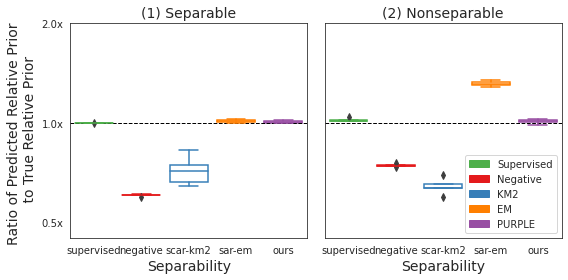

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
modes = ['separable', 'overlap']
for i, mode in enumerate(modes):
    our_results = separability_results_df[separability_results_df['method'] == 'ours']
    other_results = separability_results_df[separability_results_df['method'] != 'ours']
    our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run', 'separability_assumption']).head(1)
    expmt_results = pd.concat([our_results, other_results])
    expmt_results = expmt_results[expmt_results['separability_assumption'] == mode]
    
    g = sns.boxplot(x='method', y='rel_prior_err_pct', 
                     data=expmt_results, 
                     order=hue_order, ax=axs[i], zorder=2)
    
    g.set_yscale('log', base=2)
    axs[i].set_xlabel("Separability")
    axs[i].axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
    if i == 0:
        axs[i].set_ylabel("Ratio of Predicted Relative Prior \n to True Relative Prior")
    else:
        axs[i].set_ylabel("")
    
    # Change the color of the entire box to be method color
    for j,box in enumerate(axs[i].artists):
        color = method_colors[j]
        box.set_edgecolor(color)
        box.set_facecolor('white')
        for k in range(6*j,6*(j+1)):
             axs[i].lines[k].set_color(color)
                
    axs[i].set_ylim([.45, 2.0])
    axs[i].set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])

axs[0].set_title("(1) Separable")
axs[1].set_title("(2) Nonseparable")
# Make legend
patches = []
for method_name, method_color in zip(hue_order, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in hue_order]
axs[1].legend(handles = patches, labels = labels,loc = 'lower right')

    
plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_separability.pdf', dpi=300)  


# Figure  2c: Robustness to Covariate Shift.

<ipython-input-2-97cbc9a72ce4>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])


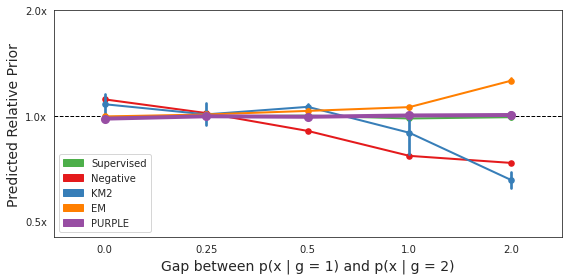

In [2]:
plt.figure(figsize=(8,4))

group_gap_results_df = group_gap_results_df[group_gap_results_df['method'].isin(plotted_methods)]

# Select performance our method based on val_loss_key
our_results = group_gap_results_df[group_gap_results_df['method'] == 'ours']
other_results = group_gap_results_df[group_gap_results_df['method'] != 'ours']
our_results = our_results.sort_values([val_loss_key], ascending=False).groupby(['group_gap', 'run']).head(1)
group_gap_results_df = pd.concat([our_results, other_results])
group_gap_results_df['abs_group_gap'] = np.abs(group_gap_results_df['group_gap'])

g = sns.pointplot(x='abs_group_gap', y='rel_prior_err_pct', hue='method', data=group_gap_results_df, 
            hue_order = plotted_methods, scale=.75, 
            linestyles=['-', '-', '-', '-', '-'], palette=method_colors)
plt.xlabel("Gap between p(x | g = 1) and p(x | g = 2)")

g.set_yscale('log', base=2)
g.set_ylim(.45, 2.0)
g.set_yticklabels(["", "",  "0.5x", "1.0x", "2.0x"])

# alpha=.5
# plt.setp(g.collections[:-1], alpha=alpha) #for the markers
# plt.setp(g.lines[:-6], alpha=alpha)

linewidth=4
plt.setp(g.collections[-1], linewidth=linewidth) #for the markers
plt.setp(g.lines[-6:], linewidth=linewidth)
# g.set_yticklabels([])
plt.ylabel("")

g.set_ylabel("Predicted Relative Prior")

plt.axhline(y=1.0, color='black', linestyle='--', zorder=1,
            linewidth=1)
# g.get_legend().remove()

patches = []
for method_name, method_color in zip(hue_order, method_colors):
    patches.append(mpatches.Patch(color=method_color, label=method_name))
labels = [method_name_dict[m] for m in hue_order]
ax = plt.gca()
ax.legend(handles = patches, labels = labels,loc = 'lower left')

plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_covariate_shift.pdf', dpi=300)  


# Figure 2d: Robustness to Violations of Covariate Shift.

In [ ]:
results_df = pd.concat([pd.read_csv('./results/robustness_ours_underestimate_results'),
                        pd.read_csv('./results/robustness_supervised_underestimate_results'),
                        pd.read_csv('./results/robustness_sar-em_underestimate_results'),
                        pd.read_csv('./results/robustness_scar-km2_underestimate_results'),
                        pd.read_csv('./results/robustness_negative_underestimate_results')],
                       ignore_index=True)
results_df = pd.read_csv('./results/robustness_ours_underestimate_results')
results_df = add_metrics_to_df(results_df)

# g2_mean is stored as vector - g1 mean = 1, so we add a column 
# corresponding to the g2 mean
results_df['g2_mean_scalar'] = 1 + results_df['group_gap']
set(results_df['g2_mean_scalar'])

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
group_gap_results  = results_df
colors = ['#f2f0f7', '#cbc9e2', '#9e9ac8', '#756bb1', '#54278f']
plt.figure(figsize=(8,4))
g = sns.lineplot(x='p_y_diff', y='rel_prior_err_pct', hue='g2_mean_scalar',
             marker='o',
             hue_order=[1, .75, .5, 0, -1.0],
             palette=colors,
             data=group_gap_results)
plt.xlabel("Difference in p(y|x,g) between groups \np( y = 1 | x, g = a) - p( y = 1 | x, g = b)")
plt.ylabel("Ratio of Predicted Relative Prevalence \n to True Relative Prevalence")

g.set_ylim([.5, 1.1])
g.set_yticks([.6, .8, 1.0])
g.set_yticklabels(["0.6x", "0.8x",  "1.0x"])

g.axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
g.get_legend().set_title('$E[x|g=b]$')

plt.tight_layout()
plt.savefig(FIG_DIR + 'synthetic_robustness.pdf', format='pdf', dpi=600)

# Statistical Comparisons

In [21]:
# Across separability assumptions
sep_assumption = 'overlap'
for sep_assumption in ['separable', 'overlap']:
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        print("Separability Assumption: ", sep_assumption, "Method: ", method)
        expmt_results = separability_results_df[separability_results_df['separability_assumption'] == sep_assumption]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        print(ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct']))
        print()

Separability Assumption:  separable Method:  negative
Ttest_relResult(statistic=205.93123095098753, pvalue=3.335754791793739e-09)

Separability Assumption:  separable Method:  scar-km2
Ttest_relResult(statistic=8.182843161071848, pvalue=0.0012147470512699431)

Separability Assumption:  separable Method:  sar-em
Ttest_relResult(statistic=-0.5950669341277632, pvalue=0.5838289301954438)

Separability Assumption:  overlap Method:  negative
Ttest_relResult(statistic=57.58469097623957, pvalue=5.445659242566299e-07)

Separability Assumption:  overlap Method:  scar-km2
Ttest_relResult(statistic=17.746128586449878, pvalue=5.923776202020907e-05)

Separability Assumption:  overlap Method:  sar-em
Ttest_relResult(statistic=-70.85150216450798, pvalue=2.37781718295864e-07)



In [22]:
# Across label frequencies
max_pvals = []
for label_freq in [.1, .3, .5, .7, .9]:
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = label_freq_results_df[label_freq_results_df['labeling_frequency_g2'] == label_freq]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Label Frequency: ", label_freq, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))
# Across covariate shifts

Label Frequency:  0.1 Method:  negative p-val:  4.0099459029364925e-06
Label Frequency:  0.1 Method:  scar-km2 p-val:  0.016472903874126307
Label Frequency:  0.1 Method:  sar-em p-val:  0.0007368709571952222
Label Frequency:  0.3 Method:  negative p-val:  1.2342109345150793e-06
Label Frequency:  0.3 Method:  scar-km2 p-val:  0.0040147986445615005
Label Frequency:  0.3 Method:  sar-em p-val:  9.892809341756885e-05
Label Frequency:  0.5 Method:  negative p-val:  6.400936109806032e-07
Label Frequency:  0.5 Method:  scar-km2 p-val:  0.00117250939416125
Label Frequency:  0.5 Method:  sar-em p-val:  1.6200512788720046e-05
Label Frequency:  0.7 Method:  negative p-val:  8.670214320923108e-06
Label Frequency:  0.7 Method:  scar-km2 p-val:  1.1122916860932053e-05
Label Frequency:  0.7 Method:  sar-em p-val:  3.92608533452191e-05
Label Frequency:  0.9 Method:  negative p-val:  2.1969000789601827e-06
Label Frequency:  0.9 Method:  scar-km2 p-val:  0.0010042890476931207
Label Frequency:  0.9 Metho

In [23]:
# Across label frequencies
max_pvals = []
for group_gap in list(set(group_gap_results_df['group_gap'])):
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = group_gap_results_df[group_gap_results_df['group_gap'] == group_gap]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Group gap: ", group_gap, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))
# Across covariate shifts

Group gap:  -0.5 Method:  negative p-val:  2.748881577593179e-06
Group gap:  -0.5 Method:  scar-km2 p-val:  0.010633664208582309
Group gap:  -0.5 Method:  sar-em p-val:  0.010475297451309335
Group gap:  -0.25 Method:  negative p-val:  0.0028987687200010127
Group gap:  -0.25 Method:  scar-km2 p-val:  0.8359051811881766
Group gap:  -0.25 Method:  sar-em p-val:  0.16573882491150782
Group gap:  0.0 Method:  negative p-val:  9.575822995282794e-07
Group gap:  0.0 Method:  scar-km2 p-val:  0.12070159527971555
Group gap:  0.0 Method:  sar-em p-val:  0.0016831032851828674
Group gap:  -1.0 Method:  negative p-val:  7.147625281676033e-06
Group gap:  -1.0 Method:  scar-km2 p-val:  0.202902463735169
Group gap:  -1.0 Method:  sar-em p-val:  0.009971846559140723
Group gap:  -2.0 Method:  negative p-val:  3.956549685758413e-06
Group gap:  -2.0 Method:  scar-km2 p-val:  0.00011196306611149921
Group gap:  -2.0 Method:  sar-em p-val:  8.421725206321955e-05
(35.05955173021826, 0.00012197675019500667)


# Train a baseline  on simulated data

In [2]:
import torch

from sarpu.pu_learning import *
from eval_fs import eval_relative_prior
from method import train_relative_estimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from simulation_helpers import create_gap_1d, create_gap_nd
from simulation_helpers import generate_g, generate_y, generate_s_scar
from simulation_helpers import separable_decision_rule_1d, inseparable_decision_rule_1d
from simulation_helpers import separable_decision_rule_nd, inseparable_decision_rule_nd

from method import train_relative_estimator, get_loss
from baselines import cdmm, supervised_rel_prior, sar_em_rel_prior, scar_km2_rel_prior

### Generating data for each group.

Parameters that you can plan with are $c_1$, $c_2$, group_gap, and separability assumption ('separable', 'overlap', 'overlaid'). In addition, you can change std, the standard deviation of the Gaussian distributions for each group, n_to_sample, and n_attributes.

In [4]:
# Parameter settings
c1 = .5
c2 = .3
n_groups = 2
group_gap = -2
scar_assumption = True
separability_assumption = 'overlap'
std, n_to_sample, n_attributes = 16, 10000, 5
n_epochs = 10000

n_to_sample_g1 = n_to_sample
n_to_sample_g2 = 2*n_to_sample

g1_mean = np.ones(n_attributes)
g2_mean =  g1_mean + group_gap
g1_config = {'mean': g1_mean, 'std': std, 'n_samples': n_to_sample_g1, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 1, 'n_epochs':n_epochs,
                 'group1_idx': 0}
g1_config['lamda'] = 0
g2_config = {'mean': g2_mean, 'std': std, 'n_samples': n_to_sample_g2, 
             'n_attributes': n_attributes, 'n_groups': n_groups, 'group_feat': 2, 
             'group1_idx': 0}

expmt_config = {'scar_assumption': scar_assumption, 
                'separability_assumption': separability_assumption, 
                'labeling_frequency_g1': c1, 'labeling_frequency_g2': c2, 
                 'group1_idx': 0} 

In [5]:
x1 = generate_g(g1_config)
x2 = generate_g(g2_config)

if expmt_config['separability_assumption'] == 'separable':
    y1 = generate_y(x1, g1_config, separable_decision_rule_nd)
    y2 = generate_y(x2, g2_config, separable_decision_rule_nd)
    x1, y1 = create_gap_nd(x1, y1, g1_config)
    x2, y2 = create_gap_nd(x2, y2, g2_config)
elif expmt_config['separability_assumption'] == 'overlap':
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=1)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=1)
elif expmt_config['separability_assumption'] == 'overlaid':
    beta = 1
    y1 = generate_y(x1, g1_config, inseparable_decision_rule_nd, beta=.75, scale=.75)
    y2 = generate_y(x2, g2_config, inseparable_decision_rule_nd, beta=.75, scale=.75)

# generate observed labels
if expmt_config['scar_assumption']:
    s1 = generate_s_scar(y1, expmt_config['labeling_frequency_g1'])
    s2 = generate_s_scar(y2, expmt_config['labeling_frequency_g2'])


# split into train, val, test
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
s = np.concatenate([s1, s2])

### Splitting  x, y, and s into train and test sets.

We assume that the data is stratified by group across the train and test set. That is, p(g=1) is constant across each split.

In [6]:
x1_train, x1_test, y1_train, y1_test, s1_train, s1_test = train_test_split(x1, y1, s1, test_size=.2, 
                                                                                  random_state=10, shuffle=True, stratify=y1)
x2_train, x2_test, y2_train, y2_test, s2_train, s2_test = train_test_split(x2, y2, s2, test_size=.2, 
                                                                                  random_state=10, shuffle=True, stratify=y2)

x_train = np.concatenate([x1_train, x2_train])
y_train = np.concatenate([y1_train, y2_train])
s_train = np.concatenate([s1_train, s2_train])

x_test = np.concatenate([x1_test, x2_test])
y_test = np.concatenate([y1_test, y2_test])
s_test = np.concatenate([s1_test, s2_test])

scale_factor = np.max(np.abs(x_train))
x_train_norm = x_train/scale_factor
x_test_norm = x_test/scale_factor

g1_train_idxs = x_train[:,0] == 1
g2_train_idxs = x_train[:,1] == 1
g1_test_idxs = x_test[:,0] == 1
g2_test_idxs = x_test[:,1] == 1
classification_attributes = [i + n_groups for i in range(n_attributes)]

### Quick summary of the group statistics:

In [7]:
print("--- Group-specific p(y=1) --- ")
print("p( y = 1 | g = 1 )", np.mean(y1))
print("p( y = 1 | g = 2 )", np.mean(y2))

print("--- Group-specific p(s=1) --- ")
print("p( s = 1 | g = 1 )", np.mean(s1))
print("p( s = 1 | g = 2 )", np.mean(s2))

print("--- Number of Samples ---")
print(len(x))

--- Group-specific p(y=1) --- 
p( y = 1 | g = 1 ) 0.6554
p( y = 1 | g = 2 ) 0.34415
--- Group-specific p(s=1) --- 
p( s = 1 | g = 1 ) 0.3277
p( s = 1 | g = 2 ) 0.1032
--- Number of Samples ---
30000


# Train a baseline

In [10]:
method = 'sar-em'
if method == 'supervised':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   y1_train, y2_train, x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'negative':
    results = supervised_rel_prior(x_train[g1_train_idxs], 
                                   x_train[g2_train_idxs],
                                   s_train[g1_train_idxs],
                                   s_train[g2_train_idxs], x_test, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

elif method == 'sar-em':
    results = sar_em_rel_prior(x_train_norm[g1_train_idxs],
                               x_train_norm[g2_train_idxs],
                               s_train[g1_train_idxs],
                               s_train[g2_train_idxs], x_test_norm, g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior,  models = results
    f1_model, f2_model = models
    
elif method == 'cdmm':
    results  = cdmm(x_train_norm[g1_train_idxs], x_train_norm[g2_train_idxs],
                s_train[g1_train_idxs], s_train[g2_train_idxs], g1_config)

    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models
    
elif method == 'scar-km2':
    results = scar_km2_rel_prior(x1_train, x2_train, s1_train, s2_train)
    pred_rel_prior, pred_g1_prior, pred_g2_prior, models = results
    f1_model, f2_model = models

Initialize classification and propensity model:  0.00013327598571777344
Initialize_simple call:  0.029543399810791016


  0%|          | 2/500 [00:00<00:34, 14.53it/s]

iteration:  0
Finished training propensity model:  0.00033926963806152344 (8000, 7)
Finished training classification model:  0.06461119651794434
Calculated log likelihood.
iteration:  1
Finished training propensity model:  0.0002849102020263672 (8000, 7)
Finished training classification model:  0.0555722713470459
Calculated log likelihood.
iteration:  2
Finished training propensity model:  0.0010607242584228516 (8000, 7)


  1%|          | 4/500 [00:00<00:45, 10.81it/s]

Finished training classification model:  0.11295127868652344
Calculated log likelihood.
iteration:  3
Finished training propensity model:  0.00040650367736816406 (8000, 7)
Finished training classification model:  0.09065985679626465
Calculated log likelihood.
iteration:  4
Finished training propensity model:  0.0013933181762695312 (8000, 7)
Finished training classification model:  0.04398012161254883
Calculated log likelihood.
iteration:  5
Finished training propensity model:  0.00042319297790527344 (8000, 7)
Finished training classification model:  0.04065275192260742
Calculated log likelihood.
iteration:  6
Finished training propensity model:  0.0003566741943359375 (8000, 7)


  2%|▏         | 9/500 [00:00<00:32, 15.15it/s]

Finished training classification model:  0.0666351318359375
Calculated log likelihood.
iteration:  7
Finished training propensity model:  9.775161743164062e-05 (8000, 7)
Finished training classification model:  0.04945707321166992
Calculated log likelihood.
iteration:  8
Finished training propensity model:  0.0004661083221435547 (8000, 7)
Finished training classification model:  0.05195808410644531
Calculated log likelihood.
iteration:  9
Finished training propensity model:  0.0001227855682373047 (8000, 7)
Finished training classification model:  0.0480344295501709
Calculated log likelihood.
iteration:  10
Finished training propensity model:  8.654594421386719e-05 (8000, 7)


  3%|▎         | 13/500 [00:00<00:28, 17.04it/s]

Finished training classification model:  0.046854496002197266
Calculated log likelihood.
iteration:  11
Finished training propensity model:  9.703636169433594e-05 (8000, 7)
Finished training classification model:  0.04597783088684082
Calculated log likelihood.
iteration:  12
Finished training propensity model:  8.487701416015625e-05 (8000, 7)
Finished training classification model:  0.04838204383850098
Calculated log likelihood.
iteration:  13
Finished training propensity model:  9.942054748535156e-05 (8000, 7)
Finished training classification model:  0.08078980445861816
Calculated log likelihood.
iteration:  14
Finished training propensity model:  8.20159912109375e-05 (8000, 7)


  3%|▎         | 17/500 [00:01<00:29, 16.15it/s]

Finished training classification model:  0.051537513732910156
Calculated log likelihood.
iteration:  15
Finished training propensity model:  0.0004868507385253906 (8000, 7)
Finished training classification model:  0.054433345794677734
Calculated log likelihood.
iteration:  16
Finished training propensity model:  9.274482727050781e-05 (8000, 7)
Finished training classification model:  0.049445152282714844
Calculated log likelihood.
iteration:  17
Finished training propensity model:  0.00011563301086425781 (8000, 7)
Finished training classification model:  0.057196855545043945
Calculated log likelihood.
iteration:  18
Finished training propensity model:  8.749961853027344e-05 (8000, 7)


  4%|▍         | 21/500 [00:01<00:29, 16.38it/s]

Finished training classification model:  0.051403045654296875
Calculated log likelihood.
iteration:  19
Finished training propensity model:  0.00011944770812988281 (8000, 7)
Finished training classification model:  0.054961442947387695
Calculated log likelihood.
iteration:  20
Finished training propensity model:  9.298324584960938e-05 (8000, 7)
Finished training classification model:  0.05159640312194824
Calculated log likelihood.
iteration:  21
Finished training propensity model:  0.00012421607971191406 (8000, 7)
Finished training classification model:  0.060805320739746094
Calculated log likelihood.
iteration:  22
Finished training propensity model:  9.655952453613281e-05 (8000, 7)


  5%|▌         | 25/500 [00:01<00:34, 13.69it/s]

Finished training classification model:  0.09884929656982422
Calculated log likelihood.
iteration:  23
Finished training propensity model:  0.00014019012451171875 (8000, 7)
Finished training classification model:  0.1069192886352539
Calculated log likelihood.
iteration:  24
Finished training propensity model:  8.130073547363281e-05 (8000, 7)
Finished training classification model:  0.04759049415588379
Calculated log likelihood.
iteration:  25
Finished training propensity model:  8.845329284667969e-05 (8000, 7)


  5%|▌         | 27/500 [00:01<00:43, 10.81it/s]

Finished training classification model:  0.12001466751098633
Calculated log likelihood.
iteration:  26
Finished training propensity model:  8.606910705566406e-05 (8000, 7)
Finished training classification model:  0.14311766624450684
Calculated log likelihood.
iteration:  27
Finished training propensity model:  8.511543273925781e-05 (8000, 7)


  6%|▌         | 29/500 [00:02<00:45, 10.46it/s]

Finished training classification model:  0.12511014938354492
Calculated log likelihood.
iteration:  28
Finished training propensity model:  0.00032138824462890625 (8000, 7)
Finished training classification model:  0.06940793991088867
Calculated log likelihood.
iteration:  29
Finished training propensity model:  0.0001704692840576172 (8000, 7)
Finished training classification model:  0.06680583953857422
Calculated log likelihood.
iteration:  30
Finished training propensity model:  7.43865966796875e-05 (8000, 7)


  7%|▋         | 33/500 [00:02<00:42, 11.05it/s]

Finished training classification model:  0.10775113105773926
Calculated log likelihood.
iteration:  31
Finished training propensity model:  0.00010180473327636719 (8000, 7)
Finished training classification model:  0.04933476448059082
Calculated log likelihood.
iteration:  32
Finished training propensity model:  8.058547973632812e-05 (8000, 7)
Finished training classification model:  0.07682371139526367
Calculated log likelihood.
iteration:  33
Finished training propensity model:  8.630752563476562e-05 (8000, 7)
Finished training classification model:  0.04870915412902832


  7%|▋         | 35/500 [00:02<00:37, 12.53it/s]

Calculated log likelihood.
iteration:  34
Finished training propensity model:  7.486343383789062e-05 (8000, 7)
Finished training classification model:  0.04607582092285156
Calculated log likelihood.
iteration:  35
Finished training propensity model:  8.511543273925781e-05 (8000, 7)
Finished training classification model:  0.04357171058654785
Calculated log likelihood.
iteration:  36
Finished training propensity model:  7.343292236328125e-05 (8000, 7)
Finished training classification model:  0.04336142539978027
Calculated log likelihood.
iteration:  37
Finished training propensity model:  7.390975952148438e-05 (8000, 7)


  8%|▊         | 40/500 [00:02<00:33, 13.60it/s]

Finished training classification model:  0.08951377868652344
Calculated log likelihood.
iteration:  38
Finished training propensity model:  8.916854858398438e-05 (8000, 7)
Finished training classification model:  0.03928518295288086
Calculated log likelihood.
iteration:  39
Finished training propensity model:  7.605552673339844e-05 (8000, 7)
Finished training classification model:  0.08270549774169922
Calculated log likelihood.
iteration:  40
Finished training propensity model:  8.869171142578125e-05 (8000, 7)


  9%|▉         | 45/500 [00:03<00:27, 16.42it/s]

Finished training classification model:  0.06597113609313965
Calculated log likelihood.
iteration:  41
Finished training propensity model:  7.653236389160156e-05 (8000, 7)
Finished training classification model:  0.04445481300354004
Calculated log likelihood.
iteration:  42
Finished training propensity model:  8.654594421386719e-05 (8000, 7)
Finished training classification model:  0.03821730613708496
Calculated log likelihood.
iteration:  43
Finished training propensity model:  7.557868957519531e-05 (8000, 7)
Finished training classification model:  0.038588523864746094
Calculated log likelihood.
iteration:  44
Finished training propensity model:  7.390975952148438e-05 (8000, 7)
Finished training classification model:  0.038332223892211914
Calculated log likelihood.
iteration:  45
Finished training propensity model:  8.606910705566406e-05 (8000, 7)


  9%|▉         | 47/500 [00:03<00:29, 15.11it/s]

Finished training classification model:  0.10785055160522461
Calculated log likelihood.
iteration:  46
Finished training propensity model:  7.796287536621094e-05 (8000, 7)
Finished training classification model:  0.041007041931152344
Calculated log likelihood.
iteration:  47
Finished training propensity model:  8.58306884765625e-05 (8000, 7)
Finished training classification model:  0.10836243629455566
Calculated log likelihood.
iteration:  48
Finished training propensity model:  7.62939453125e-05 (8000, 7)


 10%|█         | 52/500 [00:03<00:29, 15.25it/s]

Finished training classification model:  0.08737945556640625
Calculated log likelihood.
iteration:  49
Finished training propensity model:  8.940696716308594e-05 (8000, 7)
Finished training classification model:  0.04178738594055176
Calculated log likelihood.
iteration:  50
Finished training propensity model:  8.082389831542969e-05 (8000, 7)
Finished training classification model:  0.04073786735534668
Calculated log likelihood.
iteration:  51
Finished training propensity model:  7.319450378417969e-05 (8000, 7)
Finished training classification model:  0.0410921573638916
Calculated log likelihood.
iteration:  52
Finished training propensity model:  8.225440979003906e-05 (8000, 7)
Finished training classification model:  0.053160905838012695


 11%|█         | 54/500 [00:03<00:29, 15.35it/s]

Calculated log likelihood.
iteration:  53
Finished training propensity model:  7.343292236328125e-05 (8000, 7)
Finished training classification model:  0.06362414360046387
Calculated log likelihood.
iteration:  54
Finished training propensity model:  8.249282836914062e-05 (8000, 7)
Finished training classification model:  0.09282302856445312
Calculated log likelihood.
iteration:  55
Finished training propensity model:  7.43865966796875e-05 (8000, 7)


 12%|█▏        | 58/500 [00:04<00:28, 15.44it/s]

Finished training classification model:  0.06405234336853027
Calculated log likelihood.
iteration:  56
Finished training propensity model:  8.96453857421875e-05 (8000, 7)
Finished training classification model:  0.04364585876464844
Calculated log likelihood.
iteration:  57
Finished training propensity model:  7.748603820800781e-05 (8000, 7)
Finished training classification model:  0.04366636276245117
Calculated log likelihood.
iteration:  58
Finished training propensity model:  8.7738037109375e-05 (8000, 7)
Finished training classification model:  0.04225516319274902
Calculated log likelihood.
iteration:  59
Finished training propensity model:  7.367134094238281e-05 (8000, 7)
Finished training classification model:  0.04274344444274902


 12%|█▏        | 62/500 [00:04<00:28, 15.24it/s]

Calculated log likelihood.
iteration:  60
Finished training propensity model:  0.00013065338134765625 (8000, 7)
Finished training classification model:  0.0477290153503418
Calculated log likelihood.
iteration:  61
Finished training propensity model:  7.534027099609375e-05 (8000, 7)
Finished training classification model:  0.08792448043823242
Calculated log likelihood.
iteration:  62
Finished training propensity model:  8.630752563476562e-05 (8000, 7)


 13%|█▎        | 64/500 [00:04<00:26, 16.28it/s]

Finished training classification model:  0.044950008392333984
Calculated log likelihood.
iteration:  63
Finished training propensity model:  7.843971252441406e-05 (8000, 7)
Finished training classification model:  0.0444178581237793
Calculated log likelihood.
iteration:  64
Finished training propensity model:  8.58306884765625e-05 (8000, 7)
Finished training classification model:  0.08958697319030762
Calculated log likelihood.
iteration:  65
Finished training propensity model:  7.367134094238281e-05 (8000, 7)


 13%|█▎        | 66/500 [00:04<00:29, 14.83it/s]

Finished training classification model:  0.0569303035736084
Calculated log likelihood.
iteration:  66
Finished training propensity model:  8.440017700195312e-05 (8000, 7)
Finished training classification model:  0.1255626678466797
Calculated log likelihood.
iteration:  67
Finished training propensity model:  0.0005013942718505859 (8000, 7)


 14%|█▎        | 68/500 [00:04<00:38, 11.30it/s]

Finished training classification model:  0.1207432746887207
Calculated log likelihood.
iteration:  68
Finished training propensity model:  0.00010585784912109375 (8000, 7)
Finished training classification model:  0.08038091659545898
Calculated log likelihood.
iteration:  69
Finished training propensity model:  8.106231689453125e-05 (8000, 7)


 14%|█▍        | 71/500 [00:05<00:31, 13.49it/s]

Finished training classification model:  0.11725711822509766
Calculated log likelihood.
iteration:  70
Finished training propensity model:  9.1552734375e-05 (8000, 7)
Finished training classification model:  0.044039249420166016
Calculated log likelihood.
iteration:  71
Finished training propensity model:  8.082389831542969e-05 (8000, 7)
Finished training classification model:  0.05040788650512695
Calculated log likelihood.



/data/ddmg/prism/.conda/envs/ipv_nfs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Initialize classification and propensity model:  4.1961669921875e-05
Initialize_simple call:  0.025827407836914062


  0%|          | 0/500 [00:00<?, ?it/s]

iteration:  0
Finished training propensity model:  0.00010728836059570312 (16000, 7)
Finished training classification model:  0.06384849548339844
Calculated log likelihood.
iteration:  1
Finished training propensity model:  0.0003833770751953125 (16000, 7)


  1%|          | 4/500 [00:00<00:47, 10.39it/s]

Finished training classification model:  0.13485169410705566
Calculated log likelihood.
iteration:  2
Finished training propensity model:  9.846687316894531e-05 (16000, 7)
Finished training classification model:  0.05235028266906738
Calculated log likelihood.
iteration:  3
Finished training propensity model:  9.131431579589844e-05 (16000, 7)
Finished training classification model:  0.10719823837280273
Calculated log likelihood.
iteration:  4
Finished training propensity model:  0.00011205673217773438 (16000, 7)


  1%|          | 6/500 [00:00<00:44, 11.05it/s]

Finished training classification model:  0.10239458084106445
Calculated log likelihood.
iteration:  5
Finished training propensity model:  0.00030875205993652344 (16000, 7)
Finished training classification model:  0.05193209648132324
Calculated log likelihood.
iteration:  6
Finished training propensity model:  0.0006263256072998047 (16000, 7)
Finished training classification model:  0.06352066993713379
Calculated log likelihood.
iteration:  7
Finished training propensity model:  0.00014138221740722656 (16000, 7)


  2%|▏         | 10/500 [00:00<00:38, 12.70it/s]

Finished training classification model:  0.07371068000793457
Calculated log likelihood.
iteration:  8
Finished training propensity model:  0.00010395050048828125 (16000, 7)
Finished training classification model:  0.06261777877807617
Calculated log likelihood.
iteration:  9
Finished training propensity model:  8.940696716308594e-05 (16000, 7)
Finished training classification model:  0.05792641639709473
Calculated log likelihood.
iteration:  10
Finished training propensity model:  0.0001506805419921875 (16000, 7)


  2%|▏         | 12/500 [00:00<00:37, 13.09it/s]

Finished training classification model:  0.06704425811767578
Calculated log likelihood.
iteration:  11
Finished training propensity model:  9.012222290039062e-05 (16000, 7)
Finished training classification model:  0.060601234436035156
Calculated log likelihood.
iteration:  12
Finished training propensity model:  9.846687316894531e-05 (16000, 7)
Finished training classification model:  0.06065797805786133
Calculated log likelihood.
iteration:  13
Finished training propensity model:  0.00013899803161621094 (16000, 7)


  3%|▎         | 16/500 [00:01<00:37, 12.85it/s]

Finished training classification model:  0.06392765045166016
Calculated log likelihood.
iteration:  14
Finished training propensity model:  9.679794311523438e-05 (16000, 7)
Finished training classification model:  0.07491922378540039
Calculated log likelihood.
iteration:  15
Finished training propensity model:  8.726119995117188e-05 (16000, 7)
Finished training classification model:  0.07651662826538086
Calculated log likelihood.
iteration:  16
Finished training propensity model:  9.679794311523438e-05 (16000, 7)


  4%|▎         | 18/500 [00:01<00:37, 12.99it/s]

Finished training classification model:  0.06710672378540039
Calculated log likelihood.
iteration:  17
Finished training propensity model:  8.893013000488281e-05 (16000, 7)
Finished training classification model:  0.0654606819152832
Calculated log likelihood.
iteration:  18
Finished training propensity model:  0.00010180473327636719 (16000, 7)
Finished training classification model:  0.06800460815429688
Calculated log likelihood.
iteration:  19
Finished training propensity model:  0.0001010894775390625 (16000, 7)


  4%|▍         | 22/500 [00:01<00:36, 13.14it/s]

Finished training classification model:  0.06780719757080078
Calculated log likelihood.
iteration:  20
Finished training propensity model:  0.00010204315185546875 (16000, 7)
Finished training classification model:  0.06671261787414551
Calculated log likelihood.
iteration:  21
Finished training propensity model:  8.96453857421875e-05 (16000, 7)
Finished training classification model:  0.06478738784790039
Calculated log likelihood.
iteration:  22
Finished training propensity model:  9.584426879882812e-05 (16000, 7)


  5%|▍         | 24/500 [00:01<00:36, 13.14it/s]

Finished training classification model:  0.06998372077941895
Calculated log likelihood.
iteration:  23
Finished training propensity model:  8.749961853027344e-05 (16000, 7)
Finished training classification model:  0.0649716854095459
Calculated log likelihood.
iteration:  24
Finished training propensity model:  9.5367431640625e-05 (16000, 7)
Finished training classification model:  0.07234716415405273
Calculated log likelihood.
iteration:  25
Finished training propensity model:  8.916854858398438e-05 (16000, 7)


  5%|▌         | 26/500 [00:02<00:37, 12.77it/s]

Finished training classification model:  0.07658767700195312
Calculated log likelihood.
iteration:  26
Finished training propensity model:  9.655952453613281e-05 (16000, 7)
Finished training classification model:  0.11171770095825195
Calculated log likelihood.
iteration:  27
Finished training propensity model:  0.00038695335388183594 (16000, 7)


  6%|▌         | 28/500 [00:02<00:49,  9.46it/s]

Finished training classification model:  0.17551541328430176
Calculated log likelihood.
iteration:  28
Finished training propensity model:  0.0006895065307617188 (16000, 7)
Finished training classification model:  0.1207742691040039
Calculated log likelihood.
iteration:  29
Finished training propensity model:  0.00013399124145507812 (16000, 7)


  6%|▋         | 32/500 [00:02<00:48,  9.68it/s]

Finished training classification model:  0.10930180549621582
Calculated log likelihood.
iteration:  30
Finished training propensity model:  0.0001227855682373047 (16000, 7)
Finished training classification model:  0.07318854331970215
Calculated log likelihood.
iteration:  31
Finished training propensity model:  0.00021266937255859375 (16000, 7)
Finished training classification model:  0.07773470878601074
Calculated log likelihood.
iteration:  32
Finished training propensity model:  0.0001227855682373047 (16000, 7)


  7%|▋         | 34/500 [00:02<00:45, 10.29it/s]

Finished training classification model:  0.07909083366394043
Calculated log likelihood.
iteration:  33
Finished training propensity model:  0.00035262107849121094 (16000, 7)
Finished training classification model:  0.0711212158203125
Calculated log likelihood.
iteration:  34
Finished training propensity model:  0.00017118453979492188 (16000, 7)
Finished training classification model:  0.08043098449707031
Calculated log likelihood.
iteration:  35
Finished training propensity model:  0.00032138824462890625 (16000, 7)


  8%|▊         | 38/500 [00:03<00:42, 10.90it/s]

Finished training classification model:  0.07338762283325195
Calculated log likelihood.
iteration:  36
Finished training propensity model:  0.0004105567932128906 (16000, 7)
Finished training classification model:  0.07656478881835938
Calculated log likelihood.
iteration:  37
Finished training propensity model:  0.00035881996154785156 (16000, 7)
Finished training classification model:  0.08014273643493652
Calculated log likelihood.
iteration:  38
Finished training propensity model:  0.0001049041748046875 (16000, 7)


  8%|▊         | 40/500 [00:03<00:41, 11.14it/s]

Finished training classification model:  0.07247757911682129
Calculated log likelihood.
iteration:  39
Finished training propensity model:  9.059906005859375e-05 (16000, 7)
Finished training classification model:  0.07955312728881836
Calculated log likelihood.
iteration:  40
Finished training propensity model:  9.942054748535156e-05 (16000, 7)
Finished training classification model:  0.07831430435180664
Calculated log likelihood.
iteration:  41
Finished training propensity model:  0.00014162063598632812 (16000, 7)


  9%|▉         | 44/500 [00:03<00:40, 11.22it/s]

Finished training classification model:  0.07998394966125488
Calculated log likelihood.
iteration:  42
Finished training propensity model:  9.655952453613281e-05 (16000, 7)
Finished training classification model:  0.08069658279418945
Calculated log likelihood.
iteration:  43
Finished training propensity model:  8.821487426757812e-05 (16000, 7)
Finished training classification model:  0.07747459411621094
Calculated log likelihood.
iteration:  44
Finished training propensity model:  0.0001609325408935547 (16000, 7)


  9%|▉         | 46/500 [00:04<00:40, 11.26it/s]

Finished training classification model:  0.07846879959106445
Calculated log likelihood.
iteration:  45
Finished training propensity model:  8.7738037109375e-05 (16000, 7)
Finished training classification model:  0.07958817481994629
Calculated log likelihood.
iteration:  46
Finished training propensity model:  9.655952453613281e-05 (16000, 7)
Finished training classification model:  0.07531571388244629
Calculated log likelihood.
iteration:  47
Finished training propensity model:  0.000152587890625 (16000, 7)


 10%|█         | 50/500 [00:04<00:39, 11.27it/s]

Finished training classification model:  0.07968592643737793
Calculated log likelihood.
iteration:  48
Finished training propensity model:  9.799003601074219e-05 (16000, 7)
Finished training classification model:  0.0864109992980957
Calculated log likelihood.
iteration:  49
Finished training propensity model:  9.036064147949219e-05 (16000, 7)
Finished training classification model:  0.07521224021911621
Calculated log likelihood.
iteration:  50
Finished training propensity model:  0.00016117095947265625 (16000, 7)


 10%|█         | 52/500 [00:04<00:39, 11.31it/s]

Finished training classification model:  0.07938694953918457
Calculated log likelihood.
iteration:  51
Finished training propensity model:  8.749961853027344e-05 (16000, 7)
Finished training classification model:  0.07696747779846191
Calculated log likelihood.
iteration:  52
Finished training propensity model:  0.0001964569091796875 (16000, 7)
Finished training classification model:  0.07651972770690918
Calculated log likelihood.
iteration:  53
Finished training propensity model:  8.726119995117188e-05 (16000, 7)


 11%|█         | 56/500 [00:04<00:38, 11.41it/s]

Finished training classification model:  0.08018684387207031
Calculated log likelihood.
iteration:  54
Finished training propensity model:  9.679794311523438e-05 (16000, 7)
Finished training classification model:  0.07497477531433105
Calculated log likelihood.
iteration:  55
Finished training propensity model:  8.749961853027344e-05 (16000, 7)
Finished training classification model:  0.08105683326721191
Calculated log likelihood.
iteration:  56
Finished training propensity model:  9.655952453613281e-05 (16000, 7)


 12%|█▏        | 58/500 [00:05<00:39, 11.18it/s]

Finished training classification model:  0.08450770378112793
Calculated log likelihood.
iteration:  57
Finished training propensity model:  0.0005600452423095703 (16000, 7)
Finished training classification model:  0.08193349838256836
Calculated log likelihood.
iteration:  58
Finished training propensity model:  0.0007410049438476562 (16000, 7)


 12%|█▏        | 60/500 [00:05<00:46,  9.40it/s]

Finished training classification model:  0.17870426177978516
Calculated log likelihood.
iteration:  59
Finished training propensity model:  0.0003924369812011719 (16000, 7)
Finished training classification model:  0.08048701286315918
Calculated log likelihood.
iteration:  60
Finished training propensity model:  0.00014734268188476562 (16000, 7)


 13%|█▎        | 63/500 [00:05<00:44,  9.81it/s]

Finished training classification model:  0.0940694808959961
Calculated log likelihood.
iteration:  61
Finished training propensity model:  0.00011682510375976562 (16000, 7)
Finished training classification model:  0.08224368095397949
Calculated log likelihood.
iteration:  62
Finished training propensity model:  0.000331878662109375 (16000, 7)
Finished training classification model:  0.09131979942321777
Calculated log likelihood.
iteration:  63
Finished training propensity model:  0.0001068115234375 (16000, 7)


 13%|█▎        | 65/500 [00:05<00:43, 10.04it/s]

Finished training classification model:  0.08585429191589355
Calculated log likelihood.
iteration:  64
Finished training propensity model:  0.0003757476806640625 (16000, 7)
Finished training classification model:  0.08488106727600098
Calculated log likelihood.
iteration:  65
Finished training propensity model:  9.512901306152344e-05 (16000, 7)
Finished training classification model:  0.08687996864318848
Calculated log likelihood.
iteration:  66
Finished training propensity model:  0.00036025047302246094 (16000, 7)


 14%|█▍        | 69/500 [00:06<00:41, 10.37it/s]

Finished training classification model:  0.08466029167175293
Calculated log likelihood.
iteration:  67
Finished training propensity model:  0.0001633167266845703 (16000, 7)
Finished training classification model:  0.08316397666931152
Calculated log likelihood.
iteration:  68
Finished training propensity model:  0.0005030632019042969 (16000, 7)
Finished training classification model:  0.08524155616760254
Calculated log likelihood.
iteration:  69
Finished training propensity model:  0.00011968612670898438 (16000, 7)


 14%|█▍        | 71/500 [00:06<00:38, 11.12it/s]

Finished training classification model:  0.06467890739440918
Calculated log likelihood.
iteration:  70
Finished training propensity model:  8.296966552734375e-05 (16000, 7)
Finished training classification model:  0.06920242309570312
Calculated log likelihood.
iteration:  71
Finished training propensity model:  0.0001010894775390625 (16000, 7)
Finished training classification model:  0.05142664909362793
Calculated log likelihood.
iteration:  72
Finished training propensity model:  0.0003094673156738281 (16000, 7)


 15%|█▍        | 73/500 [00:06<00:36, 11.67it/s]

Finished training classification model:  0.08859443664550781
Calculated log likelihood.
iteration:  73
Finished training propensity model:  0.00011134147644042969 (16000, 7)
Finished training classification model:  0.0856785774230957
Calculated log likelihood.
iteration:  74
Finished training propensity model:  0.0004031658172607422 (16000, 7)
Finished training classification model:  0.08730459213256836
Calculated log likelihood.


 15%|█▌        | 75/500 [00:06<00:38, 11.10it/s]

iteration:  75
Finished training propensity model:  0.0004017353057861328 (16000, 7)
Finished training classification model:  0.0933539867401123
Calculated log likelihood.
iteration:  76
Finished training propensity model:  0.00024580955505371094 (16000, 7)
Finished training classification model:  0.09108853340148926


 15%|█▌        | 77/500 [00:06<00:39, 10.59it/s]

Calculated log likelihood.
iteration:  77
Finished training propensity model:  0.00020384788513183594 (16000, 7)
Finished training classification model:  0.10066533088684082
Calculated log likelihood.
iteration:  78
Finished training propensity model:  0.0002932548522949219 (16000, 7)


 16%|█▌        | 79/500 [00:07<00:41, 10.22it/s]

Finished training classification model:  0.09488940238952637
Calculated log likelihood.
iteration:  79
Finished training propensity model:  0.0001327991485595703 (16000, 7)
Finished training classification model:  0.08641743659973145
Calculated log likelihood.
iteration:  80
Finished training propensity model:  0.0026464462280273438 (16000, 7)


 16%|█▋        | 82/500 [00:07<00:45,  9.24it/s]

Finished training classification model:  0.12953996658325195
Calculated log likelihood.
iteration:  81
Finished training propensity model:  0.0009529590606689453 (16000, 7)
Finished training classification model:  0.10920333862304688
Calculated log likelihood.
iteration:  82
Finished training propensity model:  0.0006022453308105469 (16000, 7)


 17%|█▋        | 84/500 [00:07<00:42,  9.77it/s]

Finished training classification model:  0.08869552612304688
Calculated log likelihood.
iteration:  83
Finished training propensity model:  0.0004737377166748047 (16000, 7)
Finished training classification model:  0.07508111000061035
Calculated log likelihood.
iteration:  84
Finished training propensity model:  0.00011396408081054688 (16000, 7)
Finished training classification model:  0.08034181594848633
Calculated log likelihood.
iteration:  85
Finished training propensity model:  0.0003228187561035156 (16000, 7)


 18%|█▊        | 88/500 [00:08<00:39, 10.41it/s]

Finished training classification model:  0.07884788513183594
Calculated log likelihood.
iteration:  86
Finished training propensity model:  0.00011992454528808594 (16000, 7)
Finished training classification model:  0.08493375778198242
Calculated log likelihood.
iteration:  87
Finished training propensity model:  0.00010395050048828125 (16000, 7)
Finished training classification model:  0.0828242301940918
Calculated log likelihood.
iteration:  88
Finished training propensity model:  9.918212890625e-05 (16000, 7)


 18%|█▊        | 90/500 [00:08<00:39, 10.28it/s]

Finished training classification model:  0.09126853942871094
Calculated log likelihood.
iteration:  89
Finished training propensity model:  9.584426879882812e-05 (16000, 7)
Finished training classification model:  0.09102773666381836
Calculated log likelihood.
iteration:  90
Finished training propensity model:  0.002893209457397461 (16000, 7)


 18%|█▊        | 92/500 [00:08<00:40, 10.07it/s]

Finished training classification model:  0.09568667411804199
Calculated log likelihood.
iteration:  91
Finished training propensity model:  0.0003268718719482422 (16000, 7)
Finished training classification model:  0.09282112121582031
Calculated log likelihood.
iteration:  92
Finished training propensity model:  0.0006327629089355469 (16000, 7)


 19%|█▉        | 94/500 [00:08<00:40,  9.92it/s]

Finished training classification model:  0.09494519233703613
Calculated log likelihood.
iteration:  93
Finished training propensity model:  0.000270843505859375 (16000, 7)
Finished training classification model:  0.09568643569946289
Calculated log likelihood.
iteration:  94
Finished training propensity model:  9.822845458984375e-05 (16000, 7)


 19%|█▉        | 96/500 [00:08<00:42,  9.47it/s]

Finished training classification model:  0.1063840389251709
Calculated log likelihood.
iteration:  95
Finished training propensity model:  9.703636169433594e-05 (16000, 7)
Finished training classification model:  0.09038758277893066
Calculated log likelihood.
iteration:  96
Finished training propensity model:  0.00014591217041015625 (16000, 7)


 20%|█▉        | 98/500 [00:09<00:42,  9.46it/s]

Finished training classification model:  0.09134554862976074
Calculated log likelihood.
iteration:  97
Finished training propensity model:  9.608268737792969e-05 (16000, 7)
Finished training classification model:  0.10032534599304199
Calculated log likelihood.
iteration:  98
Finished training propensity model:  9.608268737792969e-05 (16000, 7)


 20%|█▉        | 99/500 [00:09<00:42,  9.50it/s]

Finished training classification model:  0.09395194053649902
Calculated log likelihood.
iteration:  99
Finished training propensity model:  0.00013375282287597656 (16000, 7)
Finished training classification model:  0.08723330497741699
Calculated log likelihood.
iteration:  100
Finished training propensity model:  0.0003380775451660156 (16000, 7)


 20%|██        | 101/500 [00:09<00:51,  7.72it/s]

Finished training classification model:  0.2028825283050537
Calculated log likelihood.
iteration:  101
Finished training propensity model:  0.0001342296600341797 (16000, 7)
Finished training classification model:  0.09094095230102539
Calculated log likelihood.
iteration:  102
Finished training propensity model:  0.0003287792205810547 (16000, 7)


 21%|██        | 104/500 [00:09<00:47,  8.38it/s]

Finished training classification model:  0.09673213958740234
Calculated log likelihood.
iteration:  103
Finished training propensity model:  0.0007562637329101562 (16000, 7)
Finished training classification model:  0.10226559638977051
Calculated log likelihood.
iteration:  104
Finished training propensity model:  0.0004456043243408203 (16000, 7)


 21%|██        | 105/500 [00:10<00:46,  8.55it/s]

Finished training classification model:  0.08987903594970703
Calculated log likelihood.
iteration:  105
Finished training propensity model:  0.0002567768096923828 (16000, 7)


 21%|██▏       | 107/500 [00:10<00:52,  7.49it/s]

Finished training classification model:  0.1920027732849121
Calculated log likelihood.
iteration:  106
Finished training propensity model:  0.0003445148468017578 (16000, 7)
Finished training classification model:  0.09012198448181152
Calculated log likelihood.
iteration:  107
Finished training propensity model:  0.00016045570373535156 (16000, 7)


 22%|██▏       | 108/500 [00:10<01:09,  5.63it/s]

Finished training classification model:  0.2820911407470703
Calculated log likelihood.
iteration:  108
Finished training propensity model:  9.822845458984375e-05 (16000, 7)


 22%|██▏       | 110/500 [00:10<01:06,  5.87it/s]

Finished training classification model:  0.23054957389831543
Calculated log likelihood.
iteration:  109
Finished training propensity model:  0.00025773048400878906 (16000, 7)
Finished training classification model:  0.10248875617980957
Calculated log likelihood.
iteration:  110
Finished training propensity model:  0.00013375282287597656 (16000, 7)


 22%|██▏       | 111/500 [00:11<01:18,  4.97it/s]

Finished training classification model:  0.2541518211364746
Calculated log likelihood.
iteration:  111
Finished training propensity model:  0.0001499652862548828 (16000, 7)


 22%|██▏       | 112/500 [00:11<01:22,  4.73it/s]

Finished training classification model:  0.22227191925048828
Calculated log likelihood.
iteration:  112
Finished training propensity model:  9.632110595703125e-05 (16000, 7)
Finished training classification model:  0.09087347984313965
Calculated log likelihood.
iteration:  113
Finished training propensity model:  8.845329284667969e-05 (16000, 7)


 23%|██▎       | 115/500 [00:11<01:05,  5.90it/s]

Finished training classification model:  0.14397954940795898
Calculated log likelihood.
iteration:  114
Finished training propensity model:  0.00017952919006347656 (16000, 7)
Finished training classification model:  0.15015840530395508
Calculated log likelihood.
iteration:  115
Finished training propensity model:  0.00010085105895996094 (16000, 7)


 23%|██▎       | 116/500 [00:12<01:02,  6.14it/s]

Finished training classification model:  0.13025164604187012
Calculated log likelihood.
iteration:  116
Finished training propensity model:  9.393692016601562e-05 (16000, 7)


 23%|██▎       | 117/500 [00:12<01:10,  5.42it/s]

Finished training classification model:  0.22200632095336914
Calculated log likelihood.
iteration:  117
Finished training propensity model:  0.00020432472229003906 (16000, 7)


 24%|██▍       | 119/500 [00:12<01:06,  5.71it/s]

Finished training classification model:  0.2327098846435547
Calculated log likelihood.
iteration:  118
Finished training propensity model:  0.00010085105895996094 (16000, 7)
Finished training classification model:  0.09815740585327148
Calculated log likelihood.
iteration:  119
Finished training propensity model:  9.942054748535156e-05 (16000, 7)


 24%|██▍       | 120/500 [00:12<01:05,  5.76it/s]

Finished training classification model:  0.15905094146728516
Calculated log likelihood.
iteration:  120
Finished training propensity model:  0.00010156631469726562 (16000, 7)


 24%|██▍       | 122/500 [00:13<01:14,  5.06it/s]

Finished training classification model:  0.2604515552520752
Calculated log likelihood.
iteration:  121
Finished training propensity model:  0.00020194053649902344 (16000, 7)
Finished training classification model:  0.16808342933654785
Calculated log likelihood.
iteration:  122
Finished training propensity model:  0.00010251998901367188 (16000, 7)
Finished training classification model:  0.19684457778930664


 25%|██▍       | 123/500 [00:13<01:16,  4.93it/s]

Calculated log likelihood.
iteration:  123
Finished training propensity model:  0.00020265579223632812 (16000, 7)
Finished training classification model:  0.08431363105773926
Calculated log likelihood.
iteration:  124
Finished training propensity model:  8.821487426757812e-05 (16000, 7)


 25%|██▌       | 125/500 [00:13<01:13,  5.11it/s]

Finished training classification model:  0.26348066329956055
Calculated log likelihood.
iteration:  125
Finished training propensity model:  0.0001246929168701172 (16000, 7)


 25%|██▌       | 127/500 [00:14<01:29,  4.14it/s]

Finished training classification model:  0.5291824340820312
Calculated log likelihood.
iteration:  126
Finished training propensity model:  0.00010132789611816406 (16000, 7)
Finished training classification model:  0.115692138671875
Calculated log likelihood.
iteration:  127
Finished training propensity model:  0.00010919570922851562 (16000, 7)


 26%|██▌       | 128/500 [00:14<01:22,  4.49it/s]

Finished training classification model:  0.15068697929382324
Calculated log likelihood.
iteration:  128
Finished training propensity model:  0.00016117095947265625 (16000, 7)


 26%|██▌       | 129/500 [00:14<01:23,  4.44it/s]

Finished training classification model:  0.19625496864318848
Calculated log likelihood.
iteration:  129
Finished training propensity model:  0.0001838207244873047 (16000, 7)


 26%|██▌       | 131/500 [00:15<01:18,  4.72it/s]

Finished training classification model:  0.28460049629211426
Calculated log likelihood.
iteration:  130
Finished training propensity model:  0.00010132789611816406 (16000, 7)
Finished training classification model:  0.11918997764587402
Calculated log likelihood.
iteration:  131
Finished training propensity model:  0.00010085105895996094 (16000, 7)


 27%|██▋       | 133/500 [00:15<01:03,  5.75it/s]

Finished training classification model:  0.1724691390991211
Calculated log likelihood.
iteration:  132
Finished training propensity model:  0.00022840499877929688 (16000, 7)
Finished training classification model:  0.0889120101928711
Calculated log likelihood.
iteration:  133
Finished training propensity model:  0.0001068115234375 (16000, 7)


 27%|██▋       | 134/500 [00:15<01:17,  4.75it/s]

Finished training classification model:  0.26546692848205566
Calculated log likelihood.
iteration:  134
Finished training propensity model:  0.0002589225769042969 (16000, 7)


 27%|██▋       | 135/500 [00:16<01:26,  4.20it/s]

Finished training classification model:  0.2900683879852295
Calculated log likelihood.
iteration:  135
Finished training propensity model:  0.00010895729064941406 (16000, 7)


 27%|██▋       | 136/500 [00:16<01:34,  3.85it/s]

Finished training classification model:  0.2624785900115967
Calculated log likelihood.
iteration:  136
Finished training propensity model:  0.0004317760467529297 (16000, 7)


 27%|██▋       | 137/500 [00:16<01:27,  4.16it/s]

Finished training classification model:  0.1771397590637207
Calculated log likelihood.
iteration:  137
Finished training propensity model:  0.00010132789611816406 (16000, 7)


 28%|██▊       | 138/500 [00:17<01:39,  3.65it/s]

Finished training classification model:  0.33527374267578125
Calculated log likelihood.
iteration:  138
Finished training propensity model:  0.0001430511474609375 (16000, 7)
Finished training classification model:  0.1811203956604004
Calculated log likelihood.


 28%|██▊       | 140/500 [00:17<01:20,  4.48it/s]

iteration:  139
Finished training propensity model:  0.00010013580322265625 (16000, 7)
Finished training classification model:  0.15261602401733398
Calculated log likelihood.
iteration:  140
Finished training propensity model:  0.00011181831359863281 (16000, 7)


 28%|██▊       | 142/500 [00:17<01:05,  5.44it/s]

Finished training classification model:  0.10399079322814941
Calculated log likelihood.
iteration:  141
Finished training propensity model:  9.989738464355469e-05 (16000, 7)
Finished training classification model:  0.14597439765930176
Calculated log likelihood.
iteration:  142
Finished training propensity model:  0.000148773193359375 (16000, 7)


 29%|██▊       | 143/500 [00:18<01:17,  4.61it/s]

Finished training classification model:  0.2774980068206787
Calculated log likelihood.
iteration:  143
Finished training propensity model:  0.0004298686981201172 (16000, 7)


 29%|██▉       | 145/500 [00:18<01:08,  5.19it/s]

Finished training classification model:  0.16223382949829102
Calculated log likelihood.
iteration:  144
Finished training propensity model:  0.00015091896057128906 (16000, 7)
Finished training classification model:  0.1401805877685547
Calculated log likelihood.
iteration:  145
Finished training propensity model:  9.34600830078125e-05 (16000, 7)


 30%|██▉       | 148/500 [00:18<00:47,  7.46it/s]

Finished training classification model:  0.10170888900756836
Calculated log likelihood.
iteration:  146
Finished training propensity model:  0.0001289844512939453 (16000, 7)
Finished training classification model:  0.07406949996948242
Calculated log likelihood.
iteration:  147
Finished training propensity model:  0.00033736228942871094 (16000, 7)
Finished training classification model:  0.09677672386169434
Calculated log likelihood.
iteration:  148
Finished training propensity model:  0.0001628398895263672 (16000, 7)


 30%|███       | 150/500 [00:18<00:47,  7.33it/s]

Finished training classification model:  0.09065651893615723
Calculated log likelihood.
iteration:  149
Finished training propensity model:  8.249282836914062e-05 (16000, 7)
Finished training classification model:  0.14740681648254395
Calculated log likelihood.
iteration:  150
Finished training propensity model:  0.000225067138671875 (16000, 7)


 30%|███       | 152/500 [00:19<00:45,  7.66it/s]

Finished training classification model:  0.07736659049987793
Calculated log likelihood.
iteration:  151
Finished training propensity model:  0.00036716461181640625 (16000, 7)
Finished training classification model:  0.13534140586853027
Calculated log likelihood.
iteration:  152
Finished training propensity model:  0.0003027915954589844 (16000, 7)


 31%|███       | 153/500 [00:19<01:04,  5.39it/s]

Finished training classification model:  0.38136959075927734
Calculated log likelihood.
iteration:  153
Finished training propensity model:  0.0003883838653564453 (16000, 7)


 31%|███       | 154/500 [00:19<01:11,  4.82it/s]

Finished training classification model:  0.2466719150543213
Calculated log likelihood.
iteration:  154
Finished training propensity model:  0.0002281665802001953 (16000, 7)


 31%|███       | 156/500 [00:20<01:09,  4.92it/s]

Finished training classification model:  0.23593854904174805
Calculated log likelihood.
iteration:  155
Finished training propensity model:  9.489059448242188e-05 (16000, 7)
Finished training classification model:  0.1515665054321289
Calculated log likelihood.
iteration:  156
Finished training propensity model:  0.00010442733764648438 (16000, 7)


 32%|███▏      | 158/500 [00:20<01:00,  5.69it/s]

Finished training classification model:  0.16976022720336914
Calculated log likelihood.
iteration:  157
Finished training propensity model:  9.655952453613281e-05 (16000, 7)
Finished training classification model:  0.09878993034362793
Calculated log likelihood.
iteration:  158
Finished training propensity model:  0.0002589225769042969 (16000, 7)


 32%|███▏      | 159/500 [00:20<01:02,  5.45it/s]

Finished training classification model:  0.15901827812194824
Calculated log likelihood.
iteration:  159
Finished training propensity model:  0.00021219253540039062 (16000, 7)
Finished training classification model:  0.14372920989990234
Calculated log likelihood.


 32%|███▏      | 161/500 [00:21<00:58,  5.83it/s]

iteration:  160
Finished training propensity model:  0.00018930435180664062 (16000, 7)
Finished training classification model:  0.12947654724121094
Calculated log likelihood.
iteration:  161
Finished training propensity model:  0.00017261505126953125 (16000, 7)


 33%|███▎      | 163/500 [00:21<00:55,  6.09it/s]

Finished training classification model:  0.15683555603027344
Calculated log likelihood.
iteration:  162
Finished training propensity model:  9.894371032714844e-05 (16000, 7)
Finished training classification model:  0.14087653160095215
Calculated log likelihood.
iteration:  163
Finished training propensity model:  0.0001304149627685547 (16000, 7)


 33%|███▎      | 163/500 [00:21<00:44,  7.56it/s]


Finished training classification model:  0.09456634521484375
Calculated log likelihood.


/data/ddmg/prism/.conda/envs/ipv_nfs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 0, 'Signed distance from hyperplane')

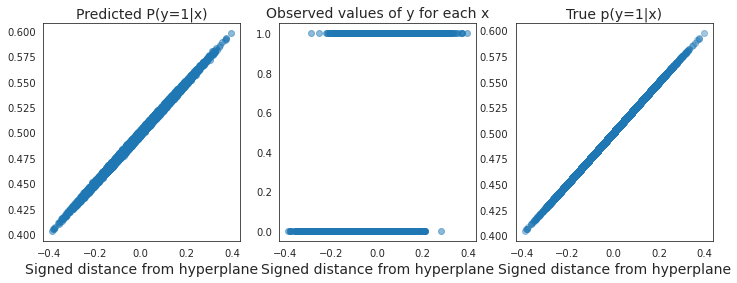

In [41]:
# Visualize predictions on training data
n_dims = g1_config['n_attributes']
y_pred = f1_model.model.predict_proba(x_train_norm[:,2:])[:,1]
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_train = np.dot(ortho_normal, x_train_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_train = features_train/normalization
y_true = (1/(1 + np.exp(-features_train*1)))

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(features_train[0], y_pred, label='pred', alpha=.5)
axs[0].set_title("Predicted P(y=1|x)")
axs[0].set_xlabel("Signed distance from hyperplane")

axs[1].scatter(features_train[0], y_train, label='true', alpha=.5)
axs[1].set_title("Observed values of y for each x")
axs[1].set_xlabel("Signed distance from hyperplane")

axs[2].scatter(features_train[0], y_true, label='p(y)', alpha=.4)
axs[2].set_title("True p(y=1|x)")
axs[2].set_xlabel("Signed distance from hyperplane")

(1, 6000) (6000,)


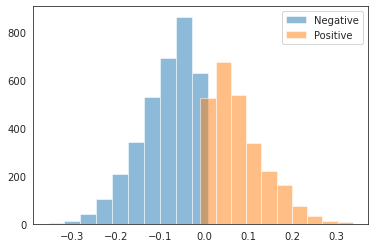

In [42]:
# Visualize predictions on test data 
y_pred = f1_model.predict_proba(x_test_norm)
ortho_normal = np.expand_dims(1*np.ones(n_attributes), 0)
features_test = np.dot(ortho_normal, x_test_norm[:,2:].T)
normalization = np.dot(ortho_normal, ortho_normal.T)[0][0]
features_test = features_test/normalization
binarized_y_pred = (y_pred > .5).astype(int)
print(features_test.shape, y_pred.shape)
plt.hist(features_test[0, binarized_y_pred == 0], alpha=.5, label='Negative')
plt.hist(features_test[0, binarized_y_pred == 1], alpha=.5, label='Positive')
plt.legend()

In [45]:
pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f1_model, 
                                                                   f2_model, g1_config['group1_idx'],
                                                                   g1_config['n_groups'])
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_g1_prior/pred_g2_prior)
print("Rel Error:", (pred_g1_prior/pred_g2_prior) / (true_g1_prior/true_g2_prior) )

Pred G1 Prior:  0.6573670058298918 Pred G2 Prior:  0.34814116743704737
True G1 Prior:  0.666 True G2 Prior:  0.34525
True Relative Prior:  1.9290369297610428
Pred Relative Prior:  1.8882196859087634
Rel Error: 0.9788406104504512


# Train our model

In [15]:
# Set regularization parameter
g1_config['estimator_type'] = 'logreg'
g1_config['optimizer'] = 'Adam'
g1_config['group_weights'] = (1, 1)
g1_config['n_epochs'] = 1000
f_model, losses, info = train_relative_estimator(x_train, s_train, x_test, s_test, g1_config, save_model=True)
# pred_rel_prior, pred_g1_prior, pred_g2_prior = eval_relative_prior(x_test, f_model)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("CE Loss")

100%|██████████| 1000/1000 [00:21<00:00, 46.92it/s]


TypeError: eval_relative_prior() missing 3 required positional arguments: 'f2_model', 'group1_idx', and 'n_groups'

In [16]:
print(info['auc'], info['auprc'])

0.7743670761477282 0.37612493253438795


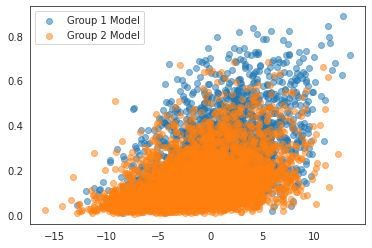

In [8]:
# Visual check to see if the same decision rule is learned for both group 1 & group 2
y1_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g1_test_idxs,2:]).cuda()).detach().cpu().numpy().squeeze()
y2_test_pred = f_model.estimate_p_y(torch.Tensor(x_test[g2_test_idxs,2:]).cuda()).detach().cpu().numpy().squeeze()
plt.scatter(x_test[g1_test_idxs,2], y1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2], y2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [11]:
np.mean(y1_test_pred) + np.mean(y2_test_pred), np.mean(s1_train) + np.mean(s2_train)

(0.4308337, 0.43624999999999997)

In [18]:
# Looking at weights - based on generative model, weights are equal to one another in the true solution
f_model.p_y_coeffs.weight, f_model.p_y_coeffs.bias, f_model.get_c_g()

(Parameter containing:
 tensor([[0.2102, 0.2028, 0.2323, 0.1941, 0.2035]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([0.0042], device='cuda:0', requires_grad=True),
 tensor([[0.8029, 0.6358]], device='cuda:0', grad_fn=<SigmoidBackward>))

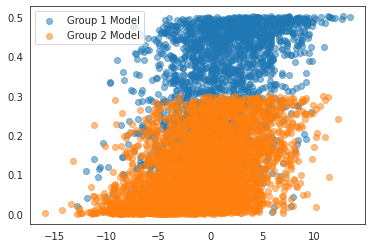

In [19]:
# Plot p(s|x)
s1_test_pred = f_model(torch.Tensor(x_test[g1_test_idxs]).cuda()).detach().cpu().numpy().squeeze()
s2_test_pred = f_model(torch.Tensor(x_test[g2_test_idxs]).cuda()).detach().cpu().numpy().squeeze()

plt.scatter(x_test[g1_test_idxs,2], s1_test_pred,  alpha=.5, label='Group 1 Model')
plt.scatter(x_test[g2_test_idxs,2],s2_test_pred, alpha=.5, label='Group 2 Model')
plt.legend()

In [20]:
true_g1_prior = y_test[g1_test_idxs].mean()
true_g2_prior = y_test[g2_test_idxs].mean()
print("Pred G1 Prior: ", pred_g1_prior, "Pred G2 Prior: ", pred_g2_prior)
print("True G1 Prior: ", true_g1_prior, "True G2 Prior: ", true_g2_prior)
print("True Relative Prior: ", true_g1_prior/true_g2_prior)
print("Pred Relative Prior: ", pred_rel_prior)

Pred G1 Prior:  0.6492879390716553 Pred G2 Prior:  0.3422531485557556
True G1 Prior:  0.6555 True G2 Prior:  0.34425
True Relative Prior:  1.904139433551198
Pred Relative Prior:  1.8970985412597656


## Train an unconstrained model

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, s_train)

from sklearn.metrics import roc_auc_score, average_precision_score
preds = lr.predict_proba(x_test)[:,1]
roc_auc_score(s_test, preds), average_precision_score(s_test, preds)

(0.772224281472956, 0.3740141532111608)

In [32]:
lr.predict_proba(x_test)[:,1].shape

(6000,)

In [33]:
s_test.shape

(6000,)

In [28]:
x_test.shape, s_test.shape, y_test.shape

((6000, 7), (8000,), (6000,))